In [1]:
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

In [2]:
circuit = QuantumCircuit(2,1)

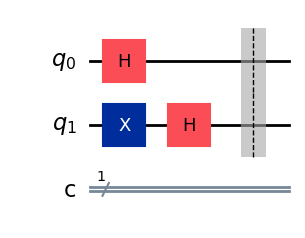

In [3]:
circuit.h(0)
circuit.x(1)
circuit.h(1)
circuit.barrier()
circuit.draw(output='mpl')

## 🧩 1. Why the Oracle Function Must Be Reversible and Unitary

In quantum computing, every operation must be represented by a **unitary operator** $U$, satisfying:

$$
U^{\dagger} U = I
$$

This condition ensures the transformation is **reversible** — no information is lost and the total probability remains 1.

Classical functions like $f(x)$ can be *irreversible* (e.g., two inputs giving the same output).  
To make such functions valid in quantum mechanics, we embed them into a **reversible form**:

$$
U_f: |x\rangle|y\rangle \rightarrow |x\rangle|y \oplus f(x)\rangle
$$

- The first register $|x\rangle$ (the **control**) remains unchanged.  
- The second register $|y\rangle$ (the **target**) stores the XOR (⊕) of its value with $f(x)$.

This XOR structure guarantees:
- **Reversibility** – we can always recover $x$ and $y$ from the output.  
- **Unitarity** – no amplitude is duplicated or destroyed.  
- **Interference compatibility** – phase information is preserved for quantum algorithms.

Hence, every quantum **oracle** (including those in Deutsch, Deutsch–Jozsa, and Bernstein–Vazirani algorithms) must be defined in this reversible $|x\rangle|y \oplus f(x)\rangle$ form.


---

## ⚙️ 2. Why the CNOT Gate Is the Correct Oracle Form

For the one-bit Deutsch algorithm, we typically choose:

$$
U_f|x\rangle|y\rangle = |x\rangle|y \oplus f(x)\rangle
$$

If we encode the function $f(x) = x$, this becomes:

$$
U_f|x,y\rangle = |x, y \oplus x\rangle
$$

This is **exactly** the action of a **CNOT gate**:
- Control → the input qubit $x$  
- Target → the ancilla qubit $y$

Hence, CNOT implements a *balanced* oracle for $f(x)=x$, while:
- Identity ($I$) corresponds to $f(x)=0$ (constant 0)
- NOT ($X$ on target) corresponds to $f(x)=1$ (constant 1)

The CNOT gate satisfies all oracle requirements:
- ✅ **Reversible**
- ✅ **Unitary**
- ✅ **Implements XOR**
- ✅ **Produces deterministic interference** after the final Hadamard

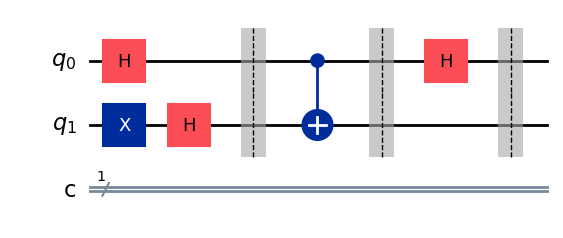

In [4]:
circuit.cx(0,1)
circuit.barrier()
circuit.h(0)
circuit.barrier()
circuit.draw(output='mpl')

In [5]:
circuit.measure(0,0)

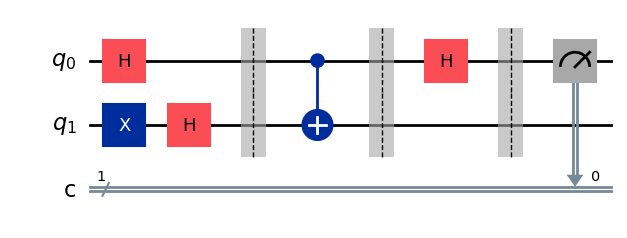

In [6]:
circuit.draw(output='mpl')

In [7]:
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)

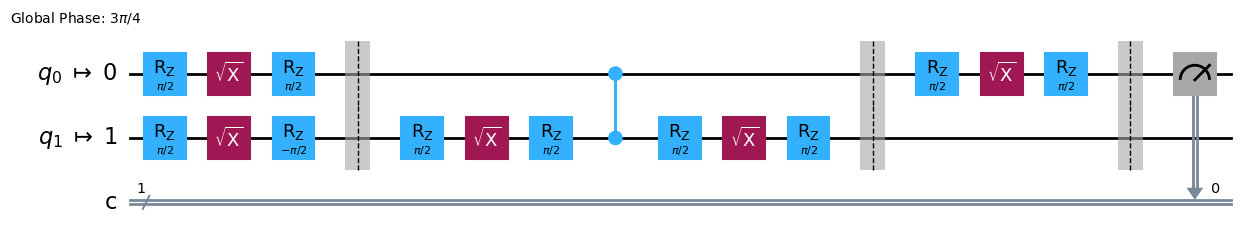

In [8]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
 
isa_circuit.draw("mpl", idle_wires=False)

In [9]:
sampler = Sampler(mode=backend)
jobSampler = sampler.run([isa_circuit], shots=1024)
result = jobSampler.result()
counts = result[0].data.c.get_counts()
print(counts)

{'1': 982, '0': 42}


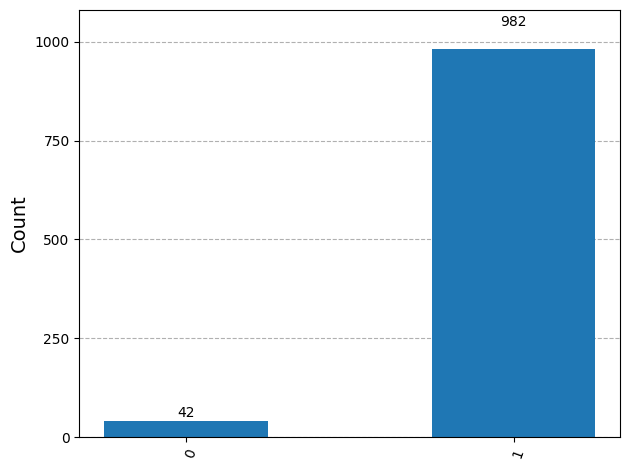

In [10]:
plot_histogram(counts)

## 🔴 3. Why the Controlled-Z Gate Is *Not* the Correct Form

A **Controlled-Z (CZ)** gate acts as:

$$
CZ|x,y\rangle =
\begin{cases}
-|x,y\rangle & \text{if } x=y=1, \\
|x,y\rangle & \text{otherwise.}
\end{cases}
$$

This means it applies a *phase flip* (−1) only on $|11\rangle$, not a bit flip.  
Therefore, its action is **phase-based**, not XOR-based.

In the Deutsch algorithm:
- The ancilla starts in $|-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}$.  
- The correct oracle (CNOT form) must **flip the ancilla** when $f(x)=1$, introducing a phase of $(−1)$ for that branch.  
- A raw CZ instead entangles the qubits and applies the phase only when both are $|1\rangle$, leading to **incomplete interference**.

Result: when using plain CZ, the measurement on the first qubit becomes **50% |0⟩ and 50% |1⟩**, instead of a deterministic outcome.

So, while CZ is **unitary** and **reversible**, it is **not in the correct oracle form** for the Deutsch algorithm.


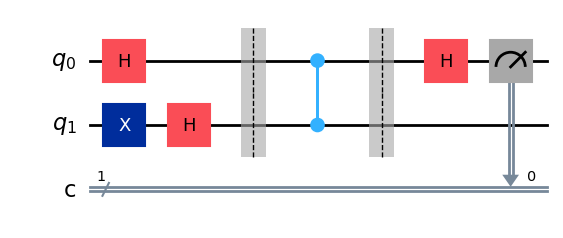

In [11]:
circuit = QuantumCircuit(2,1)
circuit.h(0)
circuit.x(1)
circuit.h(1)
circuit.barrier()
circuit.cz(0,1)
circuit.barrier()
circuit.h(0)
circuit.measure(0,0)
circuit.draw(output='mpl')

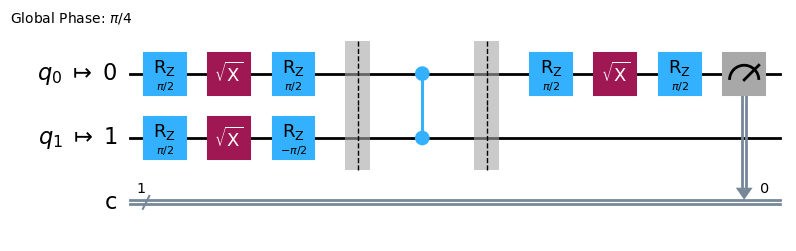

In [12]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
 
isa_circuit.draw("mpl", idle_wires=False)

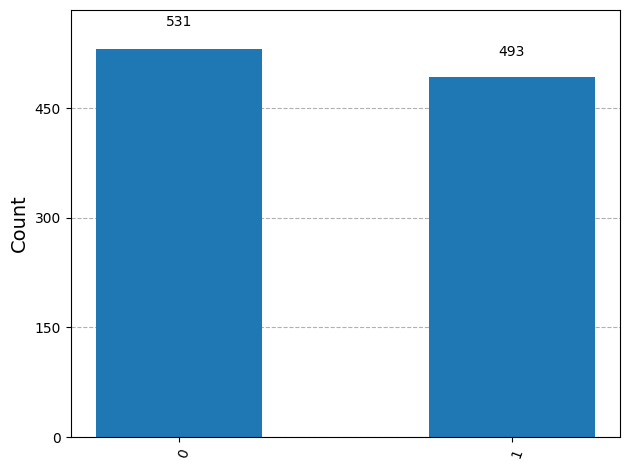

In [13]:
sampler = Sampler(mode=backend)
jobSampler = sampler.run([isa_circuit], shots=1024)
result = jobSampler.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)

## 🔄 4. How to Convert CZ into CNOT

The CZ and CNOT gates are related by a **basis transformation** on the *target* qubit using the Hadamard gate ($H$):

$$
CNOT = (I \otimes H) \, CZ \, (I \otimes H)
$$

This works because:

$$
H Z H = X
$$

which converts a **phase flip (Z)** into a **bit flip (X)**.

Thus, by wrapping CZ between two Hadamards on the target, you obtain the same XOR-style transformation as CNOT.

### ✅ Practical implementation (Qiskit syntax)
```python
qc.h(1)         # Pre-rotate target
qc.cz(0, 1)     # Apply controlled-Z
qc.h(1)         # Rotate target back

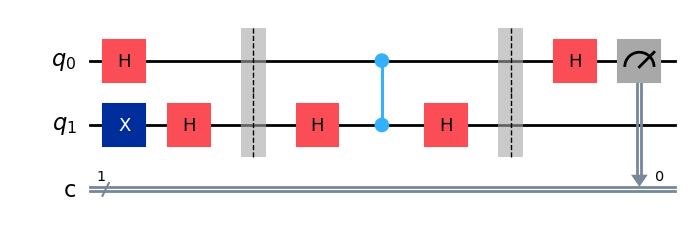

In [14]:
circuit = QuantumCircuit(2,1)
circuit.h(0)
circuit.x(1)
circuit.h(1)
circuit.barrier()
circuit.h(1)
circuit.cz(0,1)
circuit.h(1)
circuit.barrier()
circuit.h(0)
circuit.measure(0,0)
circuit.draw(output='mpl')

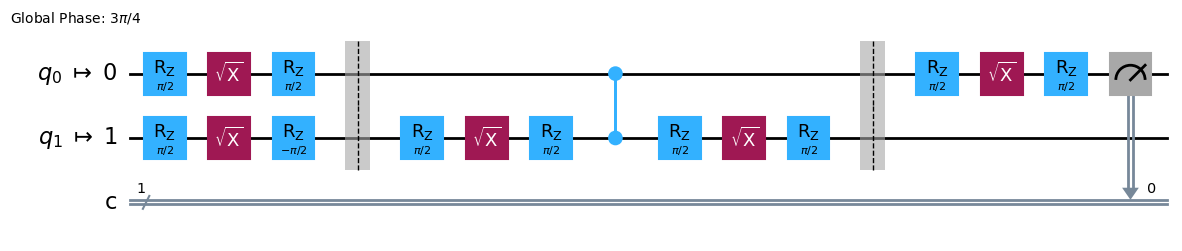

In [15]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
 
isa_circuit.draw("mpl", idle_wires=False)

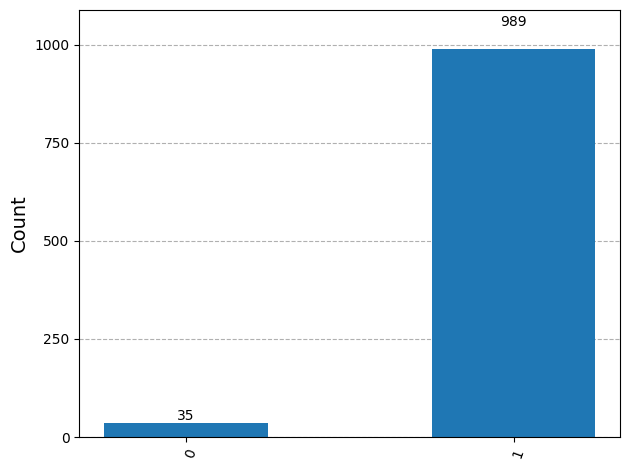

In [16]:
sampler = Sampler(mode=backend)
jobSampler = sampler.run([isa_circuit], shots=1024)
result = jobSampler.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)